In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

from src import preprocess_data

In [2]:
df = pd.read_csv("../data/games.csv", parse_dates=["date"])
df = df.dropna()

In [3]:
np.random.seed(42)

p1_white = np.random.binomial(1, 0.5, size=len(df)) == 1

In [4]:
df["white_score"] = df["result"].apply(
    lambda x: preprocess_data.get_result_integer(x, 0)
    if "/" not in x
    else preprocess_data.get_result_non_integer(x, 0)
)
df["black_score"] = df["result"].apply(
    lambda x: preprocess_data.get_result_integer(x, 1)
    if "/" not in x
    else preprocess_data.get_result_non_integer(x, 1)
)

In [5]:
df["p1_white"] = p1_white

In [6]:
def create_p1_p2_cols(df, p1_white_mask, suffix):
    df = df.copy()
    df.loc[p1_white, f"p1_{suffix}"] = df.loc[p1_white, f"white_{suffix}"]
    df.loc[~p1_white, f"p1_{suffix}"] = df.loc[~p1_white, f"black_{suffix}"]

    df.loc[p1_white, f"p2_{suffix}"] = df.loc[p1_white, f"black_{suffix}"]
    df.loc[~p1_white, f"p2_{suffix}"] = df.loc[~p1_white, f"white_{suffix}"]
    return df

In [7]:
suffixes = ["id", "elo", "title", "score"]
for suffix in suffixes:
    df = create_p1_p2_cols(df, p1_white, suffix)
df["p1_id"] = df["p1_id"].astype(np.uint64)
df["p2_id"] = df["p2_id"].astype(np.uint64)

In [8]:
train = df.loc[df["date"] < "2019-01-01"]

train_ids = list(
    set(train["p1_id"].values).union(set(train["p2_id"].values))
)

In [9]:
elo_df = pd.concat([train[["p1_id", "p1_elo"]].rename(columns={"p1_id": "id", "p1_elo": "elo"}),
train[["p2_id", "p2_elo"]].rename(columns={"p2_id": "id", "p2_elo": "elo"})])

In [10]:
id_to_elo_rating_df = elo_df.groupby("id").mean().reset_index()
id_to_elo_rating_df = id_to_elo_rating_df.sort_values("elo", ascending=False)
id_to_elo_rating_df["rank"] = range(1, len(id_to_elo_rating_df) + 1)

id_to_elo_rating_dict = id_to_elo_rating_df[["rank", "id"]].set_index("id").to_dict()["rank"]

In [40]:
ranked_ids = list(id_to_elo_rating_dict.keys())

In [11]:
train["p1_prior_rank"] = train["p1_id"].apply(
    lambda x: id_to_elo_rating_dict[x]
)
train["p2_prior_rank"] = train["p2_id"].apply(
    lambda x: id_to_elo_rating_dict[x]
)

In [13]:
num_players = len(
    set(train["p1_id"].values).union(set(train["p2_id"].values))
)
num_games = len(train)

In [15]:
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    2 * np.std(raw_prior_score, ddof=1)
)

In [17]:
train["p1_outcome"] = (1 + train["p1_score"] * 2).astype(int)
train["abs_rank_diff"] = np.abs(
    train["p1_prior_rank"].values - train["p2_prior_rank"].values
)

In [18]:
train_sorted = train.sort_values(
    ["abs_rank_diff", "p1_id"], ascending=[False, True]
)

### Set-up model

In [20]:
ordered_model = pystan.StanModel("../stan_models/fake_data_sim.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb80165351dd2b68df09c3d2e062b7aa NOW.


In [27]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "player_1_rank": train_sorted["p1_prior_rank"].values.astype(int),
    "player_2_rank": train_sorted["p2_prior_rank"].values.astype(int),
    "player_1_white": train_sorted["p1_white"].values.astype(int),
    "b_mu": 0.0,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.25, 1.25]),
    "c_scale": 0.5,
    "w_mu": 5,
    "w_scale": 0.25,
    "fit_model": 1,
    "y": train_sorted["p1_outcome"].values
}

In [30]:
fit = ordered_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [31]:
ordered_params = fit.extract(permuted=True)

ordered_inference_data = arviz.convert_to_inference_data(fit)
ordered_summary_df = (
    arviz.summary(ordered_inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [33]:
ordered_summary_df.head()

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,1.165,0.084,1.006,1.318,0.001,0.001,3356.0,3273.0,3375.0,2922.0,1.00
1,sigma_a,0.180,0.086,0.000,0.308,0.004,0.003,432.0,432.0,434.0,720.0,1.02
2,c[0],-0.708,0.071,-0.841,-0.580,0.001,0.001,4276.0,4195.0,4251.0,3238.0,1.00
3,c[1],2.026,0.085,1.856,2.171,0.001,0.001,3840.0,3808.0,3848.0,3169.0,1.00
4,raw_a[0],0.238,0.991,-1.658,2.082,0.013,0.018,5943.0,1535.0,5931.0,2294.0,1.00


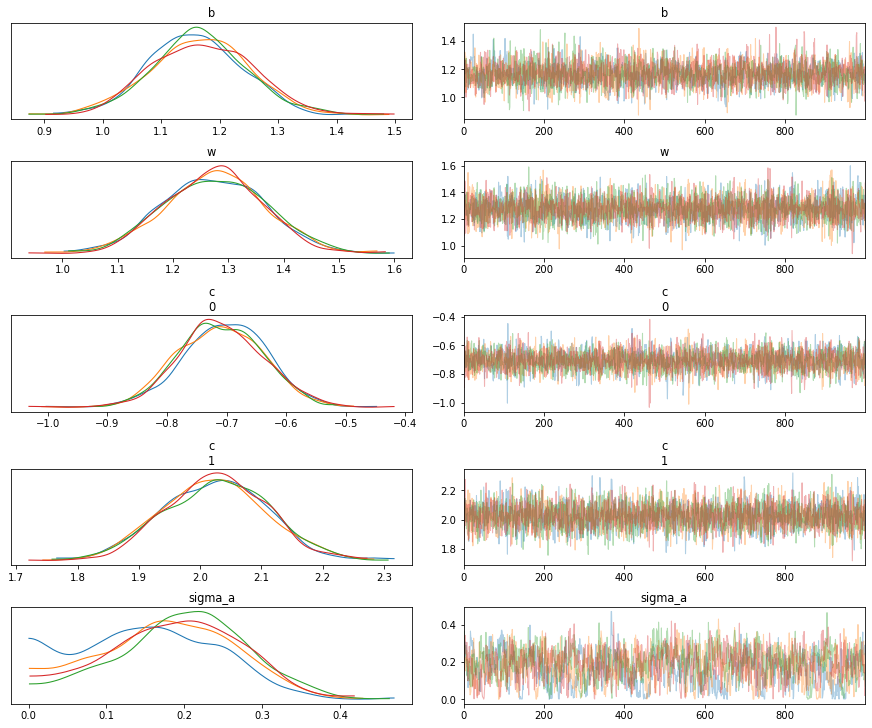

In [32]:
arviz.plot_trace(ordered_inference_data, var_names=["b", "w", "c", "sigma_a"]);

### Plotting

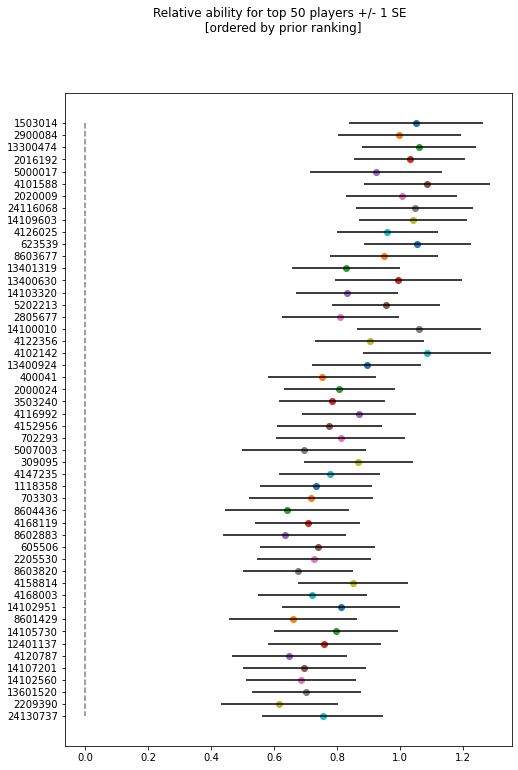

In [41]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 50

for i in range(plot_top_n_players):
    a_mean = ordered_params["a"][:, i].mean()
    a_sd = float(
        ordered_summary_df.loc[
            ordered_summary_df["parameter"] == f"a[{i}]", "sd"
        ]
    )
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)

plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.suptitle(
    f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]"
)
plt.yticks(range(1, plot_top_n_players + 1), ranked_ids[:plot_top_n_players]);

#### Look at some outcomes for games
* 3 means the P1 won.
* 2 is a draw
* 1 is the P1 lost.

In [42]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(ordered_params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out / np.mean(out.sum(1))

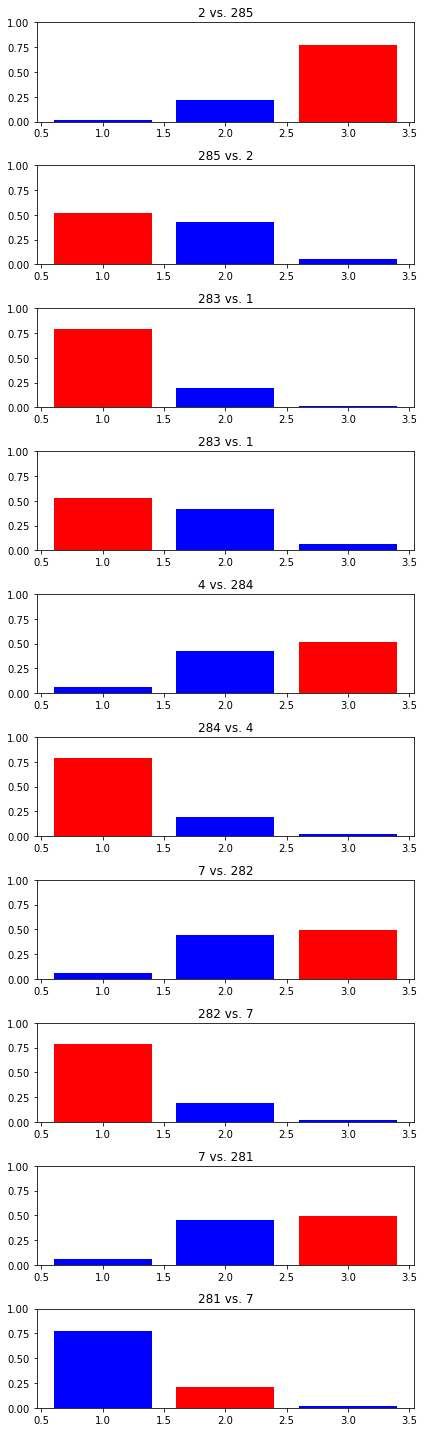

In [44]:
plot_n = 10
reverse = False
colors = ["blue"] * 3

plot_df = (
    train_sorted
    if not reverse
    else train_sorted.sort_values(
        ["abs_rank_diff", "p1_id"], ascending=[True, False]
    )
)
ranks = [
    f"{a} vs. {b}"
    for a, b in zip(
        train_sorted["p1_prior_rank"].values.astype(int),
        train_sorted["p2_prior_rank"].values.astype(int),
    )
]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[train_sorted["p1_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors)
    ax[i].set_title(f"{ranks[i]}")
    ax[i].set_ylim(0, 1)
plt.tight_layout();

In [45]:
cls_pred = np.argmax(out_prob, 1) + 1

In [47]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 0)

0.5512744516893895

In [48]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 1)

0.44042679312388855

In [49]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 2)

0.008298755186721992